In [46]:
import numpy as np
import sklearn as sk
from os import listdir
from os.path import isfile, join
import sklearn.metrics as skmetrics
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
import math
import matplotlib.pyplot as plt

In [11]:
def read_file(filename):
    with open(filename, "r") as f:
        subject = f.readline().split()[1:]
        f.readline()
        body = f.readline().split()
        distinct_words = subject + body
        is_spam = "spmsg" in filename
        return np.array(distinct_words), int(is_spam)

In [12]:
def read_part(num):
    dirname = "part" + str(num)
    files = [dirname + "/" + f for f in listdir(dirname) if isfile(join(dirname, f))]
    data = map(read_file, files)
    unziped_data = list(zip(*data))
    return list(unziped_data[0]), list(unziped_data[1])

In [13]:
def read_all_parts():
    X = []
    y = []
    for i in range(1, 11):
        cur_X, cur_y = read_part(i)
        X.extend(cur_X)
        y.extend(cur_y)
    return np.array(X), np.array(y)

In [14]:
X, y = read_all_parts()

In [15]:
# all probalities are repsresented as pairs of numinator(x[0]) and denuminator(x[1])
class Bayes(BaseEstimator):
    def __init__(self, alpha=1, lambdas=[1, 1]):
        cnt = len(lambdas)
        self.alpha = alpha
        self.lambdas = lambdas
        self.classes_cnt = cnt
        self.classes_prob = None
        self.words_prob = None
        self.distinct_words = None
        
    def fit(self, X, y):
        self.classes_prob = np.zeros((self.classes_cnt, 2), dtype=int)
        self.distinct_words = np.zeros(self.classes_cnt, dtype=int)
        self.words_prob = [{} for _ in range(self.classes_cnt)]
        
        default_word_prob = np.array([self.alpha, 0], dtype=int)
        for i in range(X.shape[0]):
            cur_words = set(X[i])
            cur_class = y[i]
            for word in cur_words:
                self.words_prob[cur_class].setdefault(word, default_word_prob)
                self.words_prob[cur_class][word][0] += 1
            self.classes_prob[cur_class][0] += 1
            
        for cur_class in range(self.classes_cnt):
            distinct = len(self.words_prob[cur_class])
            self.distinct_words[cur_class] = distinct
            self.classes_prob[cur_class][1] = self.classes_cnt
            for word in self.words_prob[cur_class].keys():
                self.words_prob[cur_class][word][1] = self.classes_prob[cur_class][0] + distinct * self.alpha
                
    
    def get_prob(self, cur_class, word):
        zero_numinator = self.alpha
        zero_denuminator = self.classes_prob[cur_class][0] + self.alpha * self.distinct_words[cur_class]
        zero_prob = np.array([zero_numinator, zero_denuminator])
        return self.words_prob[cur_class].get(word, zero_prob)
    
    
    def predict_one(self, cur_msg):
        metrics = np.log(self.classes_prob)
        cur_words = set(cur_msg)
        for cur_class in range(self.classes_cnt):
            metrics[cur_class][0] += math.log(self.lambdas[cur_class])
            for word in cur_words:
                metrics[cur_class] += np.log(self.get_prob(cur_class, word))
        return np.argmax(metrics[0] - metrics[1])
                
    def predict(self, X):
        return np.vectorize(self.predict_one)(X)

In [21]:
def get_score(y_true, y_pred):
    tmp = y_true - y_pred
    if -1 in tmp:
        return -np.inf
    else:
        return skmetrics.accuracy_score(y_true, y_pred)
my_scorer = skmetrics.make_scorer(get_score)

In [29]:
parameters_acc = {
    'alpha': [2 ** i for i in range(0, 15)],
}
clf_acc = GridSearchCV(Bayes(), parameters_acc, cv=10, n_jobs=7, scoring='accuracy')
clf_acc.fit(X, y)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Bayes(alpha=1, lambdas=[1, 1]), iid='warn', n_jobs=7,
             param_grid={'alpha': [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024,
                                   2048, 4096, 8192, 16384]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [30]:
print(clf_acc.best_params_)
print(clf_acc.best_score_)

{'alpha': 4096}
0.9779816513761468


In [31]:
parameters_f1 = {
    'alpha': [2 ** i for i in range(0, 15)],
}
clf_f1 = GridSearchCV(Bayes(), parameters_f1, cv=10, n_jobs=7, scoring='f1')
clf_f1.fit(X, y)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Bayes(alpha=1, lambdas=[1, 1]), iid='warn', n_jobs=7,
             param_grid={'alpha': [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024,
                                   2048, 4096, 8192, 16384]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [32]:
print(clf_f1.best_params_)
print(clf_f1.best_score_)

{'alpha': 4096}
0.974614620931531


In [38]:
parameters_acc_no_fp = {
    'alpha': [10 ** i for i in range(-3, 4)],
    'lambdas': [[10 ** i, 1] for i in range(60)],
}
clf_acc_no_fp = GridSearchCV(Bayes(), parameters_acc_no_fp, cv=10, n_jobs=7, scoring=my_scorer)
clf_acc_no_fp.fit(X, y)

/home/dogzik/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:763: RuntimeWarning: invalid value encountered in subtract
  array_means[:, np.newaxis]) ** 2,


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Bayes(alpha=1, lambdas=[1, 1]), iid='warn', n_jobs=7,
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'lambdas': [[1, 1], [10, 1], [100, 1], [1000, 1],
                                     [10000, 1], [100000, 1], [1000000, 1],
                                     [10000000, 1], [100000000, 1],
                                     [1000000000, 1], [10000000000, 1],
                                     [100000000000, 1], [1000000000000, 1],
                                     [10000000000000, 1], [10...
                                     [10000000000000000000000, 1],
                                     [100000000000000000000000, 1],
                                     [1000000000000000000000000, 1],
                                     [10000000000000000000000000, 1],
                                     [100000000000000000000000000, 1],
                     

In [39]:
print(clf_acc_no_fp.best_params_)
print(clf_acc_no_fp.best_score_)

{'alpha': 1, 'lambdas': [100000000000000000000000000000000000000000000000000000000, 1]}
0.7770642201834862


In [57]:
parameters_chart = {
    'alpha': [1],
    'lambdas': [[10 ** i, 1] for i in range(60)],
}
clf_chart = GridSearchCV(Bayes(), parameters_chart, cv=10, scoring=['accuracy', 'f1'], refit='f1',
                         n_jobs=7, verbose=1)
clf_chart.fit(X, y)

Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   10.3s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:   53.1s
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:  2.1min
[Parallel(n_jobs=7)]: Done 600 out of 600 | elapsed:  2.9min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Bayes(alpha=1, lambdas=[1, 1]), iid='warn', n_jobs=7,
             param_grid={'alpha': [1],
                         'lambdas': [[1, 1], [10, 1], [100, 1], [1000, 1],
                                     [10000, 1], [100000, 1], [1000000, 1],
                                     [10000000, 1], [100000000, 1],
                                     [1000000000, 1], [10000000000, 1],
                                     [100000000000, 1], [1000000000000, 1],
                                     [10000000000000, 1], [100000000000000, 1],
                                     [100000000...
                                     [10000000000000000000000, 1],
                                     [100000000000000000000000, 1],
                                     [1000000000000000000000000, 1],
                                     [10000000000000000000000000, 1],
                                     [100000000000000000000

In [59]:
xx = list(map(lambda t: t[0], parameters_chart['lambdas']))
yy_acc = clf_chart.cv_results_["mean_test_accuracy"]
yy_f1 = clf_chart.cv_results_["mean_test_f1"]

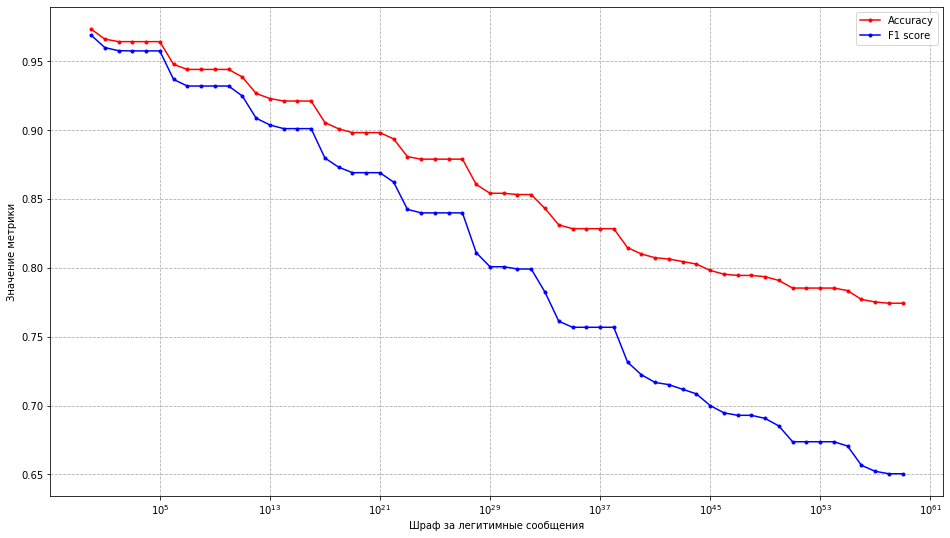

In [64]:
plt.figure(figsize=(16,9))
plt.grid(linestyle='--')
plt.semilogx(xx, yy_acc, linestyle='-',marker='.',color='r', label='Accuracy')
plt.semilogx(xx, yy_f1, linestyle='-',marker='.',color='b', label='F1 score')
plt.xlabel('Шраф за легитимные сообщения')
plt.ylabel('Значение метрики')
plt.legend()
plt.show()